In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
# Cloude shell에서 pip install geopy
from geopy.distance import distance
import matplotlib.pyplot as plt

In [73]:
fr_df = pd.read_csv('~/data/fraud.csv')

In [74]:
pd.set_option('display.max_columns', 50)

In [75]:
fr_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,NJ,7208,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,NJ,7060,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,MI,48174,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,LA,70808,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0


In [76]:
fr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

In [77]:
###  Step 1. 이것만큼은 꼭 해보세요!  ###

In [78]:
#  1. 사기거래 여부를 예측하는 데 불필요한 컬럼을 제거합니다.  #

In [79]:
# first, last, street, trans_num는 사기 감지에 의미 없음. 개인 정보 보호법 등으로 보호되어야 할 수 있음.

In [80]:
# unix_time은 trans_date_trans_time과 동일한 정보, 후자가 직관적이고 연산에 유리.

In [81]:
fr_df.drop(columns = ['merchant', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'trans_num', 'unix_time'], inplace = True)

In [82]:
fr_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0


In [83]:
#  2. 최소 2개 이상의 새로운 피처(변수)를 생성해봅시다  #

In [84]:
#  구매 금액(amt)로부터 log_amt 피쳐 생성. #

In [85]:
#  이유는 정규분포, 스케일링, 선형적, 결측치 처리 등으로 모델의 성능 향상.  #

In [86]:
fr_df['amt']

0         107.23
1          44.71
2          46.28
3          64.09
4          25.58
           ...  
491129    134.26
491130     25.49
491131    111.84
491132     86.88
491133     38.13
Name: amt, Length: 491134, dtype: float64

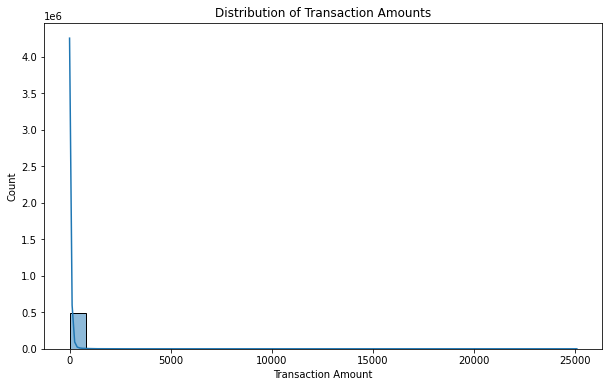

In [87]:
plt.figure(figsize=(10, 6))

# 히스토그램으로 분포 확인
sns.histplot(data=fr_df, x='amt', bins=30, kde=True)

# 그래프 제목과 축 라벨 설정
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')

# 그래프 표시
plt.show()

In [88]:
fr_df['log_amt'] = np.log(fr_df['amt'])

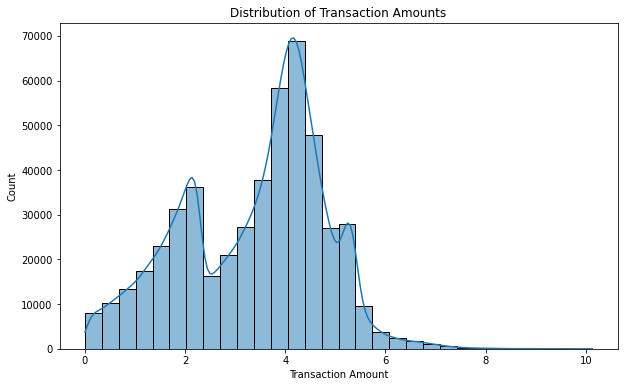

In [89]:
plt.figure(figsize=(10, 6))

# 히스토그램으로 분포 확인
sns.histplot(data=fr_df, x='log_amt', bins=30, kde=True)

# 그래프 제목과 축 라벨 설정
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')

# 그래프 표시
plt.show()

In [90]:
# amt를 log 변환 후에 선형적 관계로 시각화 되었음.

In [91]:
fr_df['log_amt']

0         4.674976
1         3.800197
2         3.834710
3         4.160288
4         3.241811
            ...   
491129    4.899778
491130    3.238286
491131    4.717069
491132    4.464528
491133    3.641001
Name: log_amt, Length: 491134, dtype: float64

In [92]:
fr_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,log_amt
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,4.674976
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0,3.800197
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0,3.834710
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0,4.160288
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0,3.241811


In [93]:
#  시간 컬럼  피쳐 생성  #

In [94]:
#  trans_date_trans_time에서 시간 정보 추출 trans_hour. #

In [95]:
#  문자열에서 datetime 타입으로 변환할 때 시간을 많이 소모했습니다. 

In [96]:
fr_df['trans_date_trans_time'] = pd.to_datetime(fr_df['trans_date_trans_time'], format = '%Y-%m-%d %H:%M:%S')

In [97]:
fr_df['trans_hour'] = fr_df['trans_date_trans_time'].dt.hour

In [98]:
fr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  491134 non-null  datetime64[ns]
 1   cc_num                 491134 non-null  int64         
 2   category               491134 non-null  object        
 3   amt                    491134 non-null  float64       
 4   gender                 491134 non-null  object        
 5   lat                    491134 non-null  float64       
 6   long                   491134 non-null  float64       
 7   city_pop               491134 non-null  int64         
 8   dob                    491134 non-null  object        
 9   merch_lat              491134 non-null  float64       
 10  merch_long             491134 non-null  float64       
 11  is_fraud               491134 non-null  int64         
 12  log_amt                491134 non-null  floa

In [99]:
fr_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,log_amt,trans_hour
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,4.674976,0
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0,3.800197,0
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0,3.834710,0
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0,4.160288,0
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0,3.241811,0


In [100]:
###  Step 2. 이런것도 해볼 수 있어요!  ###

In [101]:
#  1. 데이터의 위도/경도 정보를 활용해볼 수 있을까요?  #

In [102]:
#  고객의 위도/경도와 상점의 위도/경도의 거리 차이를 수집 #

In [103]:
def distance_diff(row):
    merch_coord = (row['merch_lat'], row['merch_long'])
    cust_coord = (row['lat'], row['long'])
    return distance(merch_coord, cust_coord).km

In [104]:
fr_df['distance_km'] = fr_df.apply(distance_diff, axis = 1)

In [105]:
fr_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,log_amt,trans_hour,distance_km
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,4.674976,0,30.216618
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0,3.800197,0,84.714605
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0,3.834710,0,67.768167
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0,4.160288,0,22.322745
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0,3.241811,0,79.398244


In [106]:
fr_df.tail()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,log_amt,trans_hour,distance_km
491129,2020-12-31 23:56:48,6011109736646996,home,134.26,F,34.2651,-77.8670,186140,1983-02-08,34.853497,-78.664158,0,4.899778,23,98.043837
491130,2020-12-31 23:56:57,213112402583773,shopping_pos,25.49,F,34.0326,-82.2027,1523,1984-06-03,35.008839,-81.475156,0,3.238286,23,127.240424
491131,2020-12-31 23:59:09,3556613125071656,kids_pets,111.84,M,29.0393,-95.4401,28739,1999-12-27,29.661049,-96.186633,0,4.717069,23,100.023736
491132,2020-12-31 23:59:15,6011724471098086,kids_pets,86.88,F,46.1966,-118.9017,3684,1981-11-29,46.658340,-119.715054,0,4.464528,23,80.887812
491133,2020-12-31 23:59:34,4170689372027579,entertainment,38.13,M,35.6665,-97.4798,116001,1993-05-10,36.210097,-97.036372,0,3.641001,23,72.380990


In [107]:
(fr_df['distance_km'] == 0).sum()

0

In [108]:
fr_df['distance_km']

0          30.216618
1          84.714605
2          67.768167
3          22.322745
4          79.398244
             ...    
491129     98.043837
491130    127.240424
491131    100.023736
491132     80.887812
491133     72.380990
Name: distance_km, Length: 491134, dtype: float64

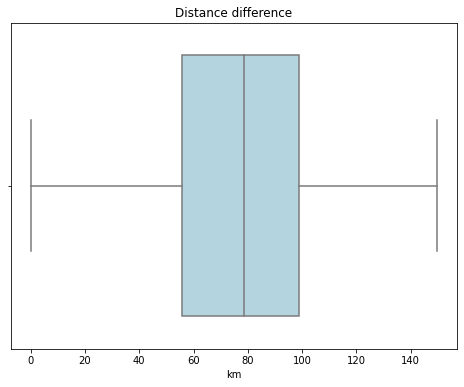

In [109]:
plt.figure(figsize=(8,6))
sns.boxplot(x=fr_df['distance_km'], color='lightblue')
plt.xlabel('km')
plt.title('Distance difference')
plt.show()

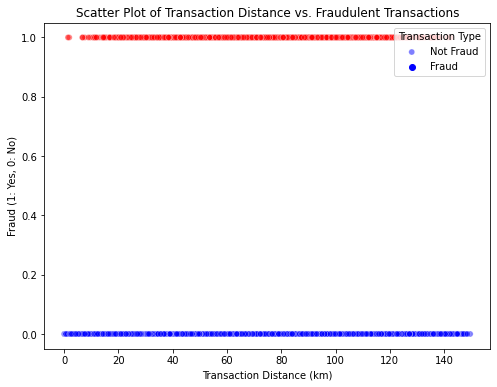

In [110]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='distance_km', y='is_fraud', data=fr_df, marker='o', hue='is_fraud', palette={0: 'blue', 1: 'red'}, alpha=0.5)
plt.xlabel('Transaction Distance (km)')
plt.ylabel('Fraud (1: Yes, 0: No)')
plt.title('Scatter Plot of Transaction Distance vs. Fraudulent Transactions')

# 레전드 업데이트
plt.legend(title='Transaction Type', labels=['Not Fraud', 'Fraud'], loc='upper right')
plt.show()

In [111]:
# 고객과 상점간의 거리와 is_fraud 간의 관계에서 선형성을 찾지 못했습니다.

In [112]:
#  2. 통계적 관점으로 접근하여 유용한 변수를 만들어낼 수 있을까요?  #

In [113]:
# amt, log_amt, trans_hour, distance_diff의 변수와 is_fraud 와의 통계로 유용한 변수를 찾아봤습니다.

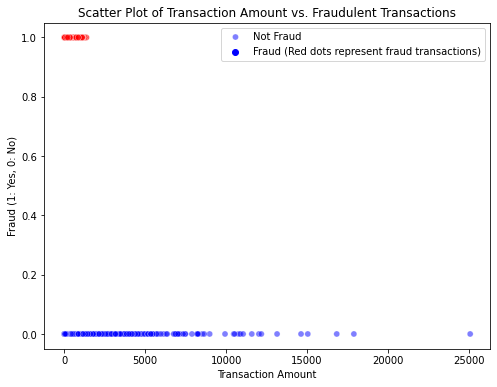

In [114]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='amt', y='is_fraud', data=fr_df, marker='o', hue='is_fraud', palette={0: 'blue', 1: 'red'}, alpha=0.5)
plt.xlabel('Transaction Amount')
plt.ylabel('Fraud (1: Yes, 0: No)')
plt.title('Scatter Plot of Transaction Amount vs. Fraudulent Transactions')
plt.legend(labels=['Not Fraud', 'Fraud (Red dots represent fraud transactions)'], loc='upper right')
plt.show()

In [115]:
# amt와 is_fraud 간에 선형성은 발견하지 못했지만 사기 거래가 적은 금액대에서 일어나는 것이 보입니다.

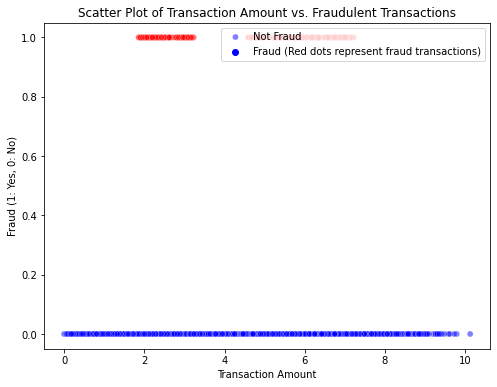

In [116]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='log_amt', y='is_fraud', data=fr_df, marker='o', hue='is_fraud', palette={0: 'blue', 1: 'red'}, alpha=0.5)
plt.xlabel('Transaction Amount')
plt.ylabel('Fraud (1: Yes, 0: No)')
plt.title('Scatter Plot of Transaction Amount vs. Fraudulent Transactions')
plt.legend(labels=['Not Fraud', 'Fraud (Red dots represent fraud transactions)'], loc='upper right')
plt.show()

In [117]:
# log_amt와 is_fraud 간의 관계에서도 선형성을 찾지 못했습니다.

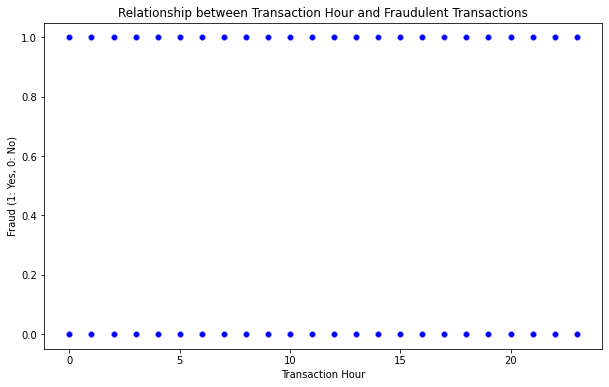

In [118]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trans_hour', y='is_fraud', data=fr_df, marker='o', color='blue', alpha=0.5)
plt.xlabel('Transaction Hour')
plt.ylabel('Fraud (1: Yes, 0: No)')
plt.title('Relationship between Transaction Hour and Fraudulent Transactions')
plt.show()

In [119]:
# trans_hour과 is_fraud 간의 관계에서도 선형성을 찾지 못했습니다.

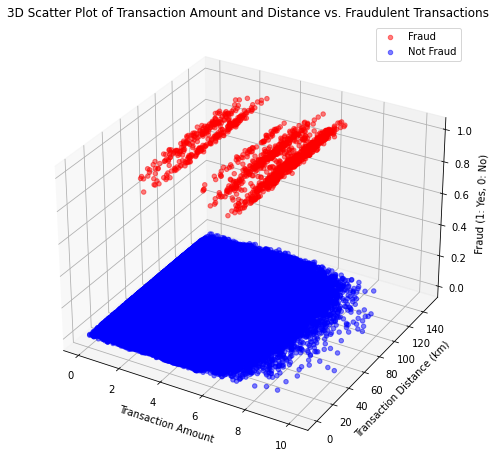

In [120]:
# 3D 산점도 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 사기 거래와 정상 거래의 데이터를 분리
fraud = fr_df[fr_df['is_fraud'] == 1]
not_fraud = fr_df[fr_df['is_fraud'] == 0]

# 사기 거래 데이터 플롯
ax.scatter(fraud['log_amt'], fraud['distance_km'], fraud['is_fraud'], c='red', marker='o', alpha=0.5, label='Fraud')

# 정상 거래 데이터 플롯
ax.scatter(not_fraud['log_amt'], not_fraud['distance_km'], not_fraud['is_fraud'], c='blue', marker='o', alpha=0.5, label='Not Fraud')

# 축 레이블 설정
ax.set_xlabel('Transaction Amount')
ax.set_ylabel('Transaction Distance (km)')
ax.set_zlabel('Fraud (1: Yes, 0: No)')
ax.set_title('3D Scatter Plot of Transaction Amount and Distance vs. Fraudulent Transactions')

# 레전드 설정
ax.legend()

plt.show()

In [121]:
# log_amt와 distance_km과 is_fraud 간의 관계에서도 선형성을 찾지 못했습니다.

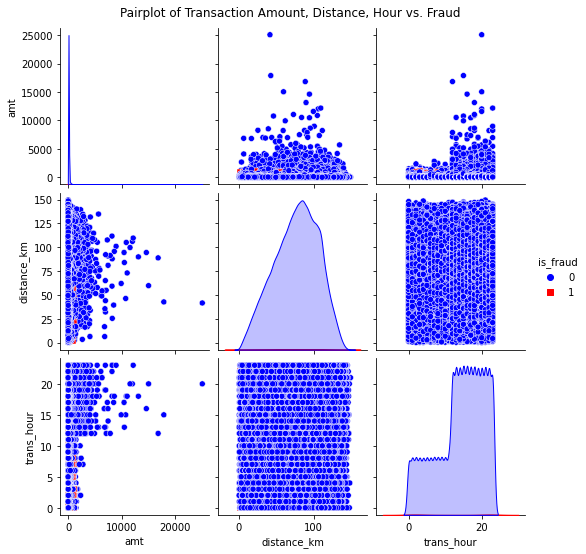

In [122]:
# Scatter plot matrix
sns.pairplot(fr_df[['amt', 'distance_km', 'trans_hour', 'is_fraud']], hue='is_fraud', diag_kind='kde', markers=['o', 's'], palette={0: 'blue', 1: 'red'})
plt.suptitle('Pairplot of Transaction Amount, Distance, Hour vs. Fraud', y=1.02)
plt.show()

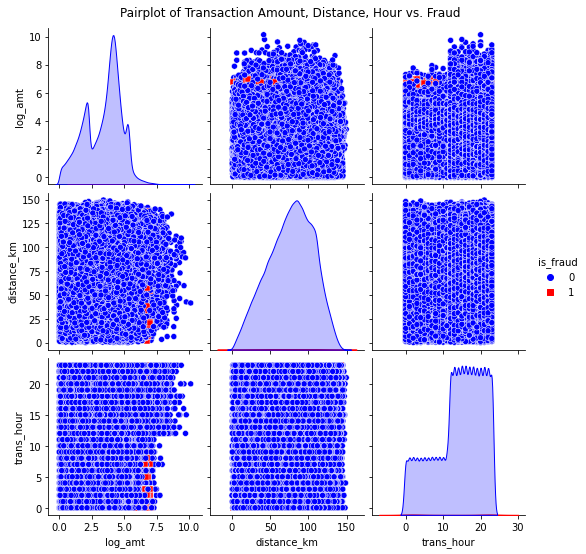

In [127]:
# Scatter plot matrix
sns.pairplot(fr_df[['log_amt', 'distance_km', 'trans_hour', 'is_fraud']], hue='is_fraud', diag_kind='kde', markers=['o', 's'], palette={0: 'blue', 1: 'red'})
plt.suptitle('Pairplot of Transaction Amount, Distance, Hour vs. Fraud', y=1.02)
plt.show()

In [ ]:
# log_amt를 쓸 때 상관관계가 조금 더 드러났습니다.

In [ ]:
# 선형성은 못 찾았지만 공통적으로 적은 금액 만큼일 때 사기 거래가 드러납니다. 

In [ ]:
# 기존 사기가 일어난 금액대에서 예측을 할 수 있을 것 같지만 그것이 유용한 값인지는 모르겠습니다.

In [124]:
###  회고  ###
# 고객과 상점간의 거리, 금액, 거래 시간대가 사기 거래에 시각화로 탐지될 만큼의 선형 관계를 찾지 못했습니다.
# 도메인 지식을 알면 통계적으로 어떤 변수가 영향을 미칠지를 추가 피처 엔지니어링으로 알 수 있을지도 모르겠습니다.
# 어떤 변수가 상관관계가 있는지를 알기 위해 선형 분석이 아닌 다양한 분석이 필요할 것 같습니다.